In [11]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import matplotlib.pyplot as plt
import argparse
import os
import os.path as osp
import numpy as np
import torch  # put this before scipy import
from scipy.misc import imread, imresize
import sys
sys.path.insert(0, '../tools')

from mattnet import MattNet

In [12]:
# box functions
def xywh_to_xyxy(boxes):
    """Convert [x y w h] box format to [x1 y1 x2 y2] format."""
    return np.hstack((boxes[:, 0:2], boxes[:, 0:2] + boxes[:, 2:4] - 1))

def show_attn(img_path, box, attn):
    """
    box : [xywh]
    attn: 49
    """
    img = imread(img_path)
    attn = np.array(attn).reshape(7,7)
    x,y,w,h = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    roi = img[y:y+h-1, x:x+w-1]
    attn = imresize(attn, [h,w])
    plt.imshow(roi)
    plt.imshow(attn, alpha=0.7)
    
def show_boxes(img_path, boxes, colors, texts=None, masks=None):
    # boxes [[xyxy]]
    img = imread(img_path)
    plt.imshow(img)
    ax = plt.gca()
    for k in range(boxes.shape[0]):
        box = boxes[k]
        xmin, ymin, xmax, ymax = list(box)
        coords = (xmin, ymin), xmax - xmin + 1, ymax - ymin + 1
        color = colors[k]
        ax.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        if texts is not None:
            ax.text(xmin, ymin, texts[k], bbox={'facecolor':color, 'alpha':0.5})
    # show mask
    if masks is not None:
        for k in range(len(masks)):
            mask = masks[k]
            m = np.zeros( (mask.shape[0], mask.shape[1], 3))
            m[:,:,0] = 0; m[:,:,1] = 0; m[:,:,2] = 1.
            ax.imshow(np.dstack([m*255, mask*255*0.4]).astype(np.uint8)) 

In [5]:
# arguments
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='refcocog', help='dataset name: refclef, refcoco, refcoco+, refcocog')
parser.add_argument('--splitBy', type=str, default='umd', help='splitBy: unc, google, berkeley')
parser.add_argument('--model_id', type=str, default='ma_g_mas_module_mean_norm_buffer_subject_wrap_20', help='model id name')
parser.add_argument('--category', type=str, default='outdoor', help='model id name')
args = parser.parse_args('')

In [6]:
# MattNet
mattnet = MattNet(args)

Loader loading data.json:  ../tools/../cache/prepro/refcocog_umd/data1.json
vocab size is  3349
object cateogry size is  80
we have 25799 images.
we have 208960 anns.
we have 49822 refs.
we have 95010 sentences.
label_length is  20
Loader loading data.h5:  ../tools/../cache/prepro/refcocog_umd/data1.h5
assigned 2600 images to split test
assigned 21899 images to split train
assigned 1300 images to split val
assigned 782 images to split test_animal
assigned 545 images to split test_indoor_img
assigned 645 images to split test_kicthen
assigned 325 images to split test_kicthen_img
assigned 4376 images to split train_indoor_img
assigned 3472 images to split train_animal_img
assigned 903 images to split val_person
assigned 300 images to split val_outdoor_img
assigned 427 images to split test_animal_img
assigned 465 images to split val_indoor
assigned 7237 images to split train_outdoor
assigned 5707 images to split train_kicthen
assigned 213 images to split val_animal_img
assigned 594 images 

IOError: [Errno 2] No such file or directory: '../tools/../output/refcocog_umd/ma_g_mas_module_mean_norm_buffer_subject_wrap_20/outdoor/ma_g_mas_module_mean_norm_buffer_subject_wrap_20.json'

In [5]:
# image path
IMAGE_DIR = '../data/images/mscoco/images/train2014'
img_path = osp.join(IMAGE_DIR, 'COCO_train2014_'+str(451842).zfill(12)+'.jpg')

../tools/../pyutils/mask-faster-rcnn/lib/nets/network.py:534: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self._image = Variable(torch.from_numpy(image.transpose([0,3,1,2])).cuda(), volatile=mode == 'TEST')
../tools/../pyutils/mask-faster-rcnn/lib/nets/network.py:237: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  rpn_cls_prob_reshape = F.softmax(rpn_cls_score_reshape)  # batch * 2 * (num_anchors*h) * w
../tools/../pyutils/mask-faster-rcnn/lib/nets/network.py:275: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  cls_prob = F.softmax(cls_score)
../tools/../pyutils/mask-faster-rcnn/lib/nets/network.py:509: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  rois = Variable(torch.from_numpy(rois).cuda(), volatile=True)
../tools/../pyutils/mask-fas

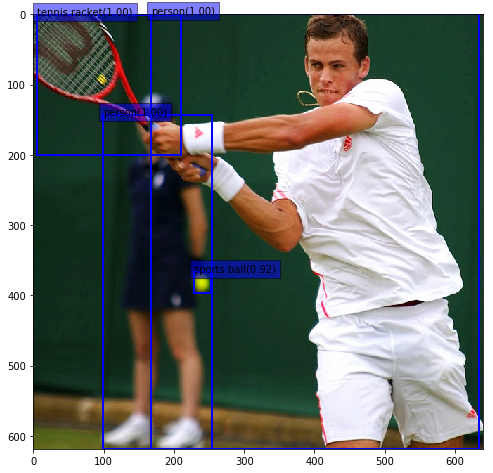

In [6]:
# forward image
img_data = mattnet.forward_image(img_path, nms_thresh=0.3, conf_thresh=0.50)
# show masks
plt.rcParams['figure.figsize'] = (10., 8.)
dets = img_data['dets']
show_boxes(img_path, xywh_to_xyxy(np.array([det['box'] for det in dets])), 
           ['blue']*len(dets), ['%s(%.2f)' % (det['category_name'], det['score']) for det in dets])

In [7]:
# comprehend expression
expr = 'The young boy spectator holds a blue umbrella while watching a softball game.'
entry = mattnet.comprehend_ground(451842, 103285)

305054
4
sports
659819
4
sports
515740
5
person


../tools/mattnet.py:308: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  max_len = (label != 0).sum().data[0]
../tools/../lib/layers/joint_match.py:184: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  weights = F.softmax(self.weight_fc(hidden)) # (n, 3)
../tools/../lib/layers/lang_encoder.py:102: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = F.softmax(cxt_scores)  # (batch, seq_len), attn.sum(1) = 1.
../tools/../lib/layers/visual_encoder.py:153: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  attn = F.softmax(attn.view(batch, grids)) # (n, 49)


[u'a', u'tennis', u'official', u'holding', u'a', u'tennis', u'ball']
[0.00036462253774516284, 0.33815041184425354, 0.035726387053728104, 0.02850545011460781, 0.006731678266078234, 0.510665774345398, 0.07985566556453705]
sub(0.46): (a,0.01)(tennis,0.25)(official,0.41)(holding,0.14)(a,0.02)(tennis,0.05)(ball,0.12)
loc(0.14): (a,0.05)(tennis,0.24)(official,0.46)(holding,0.15)(a,0.01)(tennis,0.04)(ball,0.05)
rel(0.40): (a,0.00)(tennis,0.34)(official,0.04)(holding,0.03)(a,0.01)(tennis,0.51)(ball,0.08)
[]
[u'sports ball', u'tennis racket', u'person', 'null', 'null']


/home/xieshuo/anaconda2/envs/MAttNet/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/xieshuo/anaconda2/envs/MAttNet/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/xieshuo/anaconda2/envs/MAttNet/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


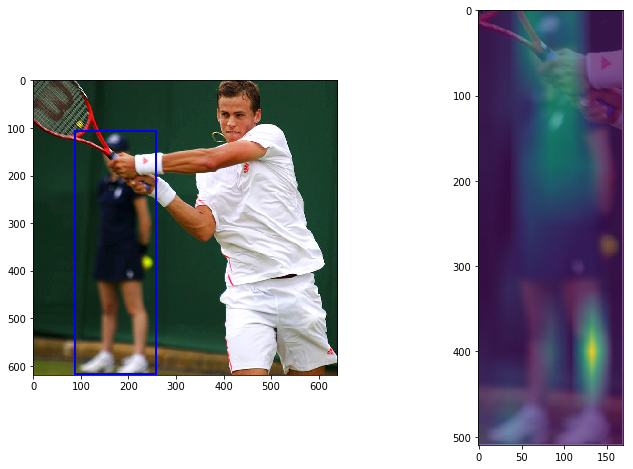

In [11]:
# visualize
tokens = entry['tokens'][0].split()
print(tokens)
print(entry['rel_attn'])
print('sub(%.2f):' % entry['weights'][0], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['sub_attn'])]))
print('loc(%.2f):' % entry['weights'][1], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['loc_attn'])]))
print('rel(%.2f):' % entry['weights'][2], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['rel_attn'])]))
# predict attribute on the predicted object
print(entry['pred_atts'])
# show prediction
plt.rcParams['figure.figsize'] = (12., 8.)
fig = plt.figure()
plt.subplot(121)
show_boxes(img_path, xywh_to_xyxy(np.vstack([entry['pred_box']])), ['blue'], texts=None, masks=None)
plt.subplot(122)
show_attn(img_path, entry['pred_box'], entry['sub_grid_attn'])

print (entry['categories'])
print (cxt_ann_ids)

sub(0.83): (The,0.02)(young,0.25)(boy,0.44)(spectator,0.08)(holds,0.05)(a,0.01)(blue,0.05)(umbrella,0.04)(while,0.02)(watching,0.03)(a,0.00)(softball,0.00)(game.,0.01)
loc(0.11): (The,0.07)(young,0.33)(boy,0.19)(spectator,0.08)(holds,0.10)(a,0.02)(blue,0.05)(umbrella,0.04)(while,0.03)(watching,0.04)(a,0.01)(softball,0.02)(game.,0.01)
rel(0.06): (The,0.00)(young,0.04)(boy,0.41)(spectator,0.03)(holds,0.02)(a,0.01)(blue,0.05)(umbrella,0.33)(while,0.02)(watching,0.02)(a,0.01)(softball,0.06)(game.,0.01)
[(u'red', 0.9999984502792358), (u'pink', 0.2279779613018036), (u'white', 0.00610385974869132), (u'child', 8.987846376840025e-05), (u'woman', 2.2781521693104878e-05)]


/home/xieshuo/anaconda2/envs/MAttNet/lib/python2.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/xieshuo/anaconda2/envs/MAttNet/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  # This is added back by InteractiveShellApp.init_path()
/home/xieshuo/anaconda2/envs/MAttNet/lib/python2.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  from ipykernel import kernelapp as app


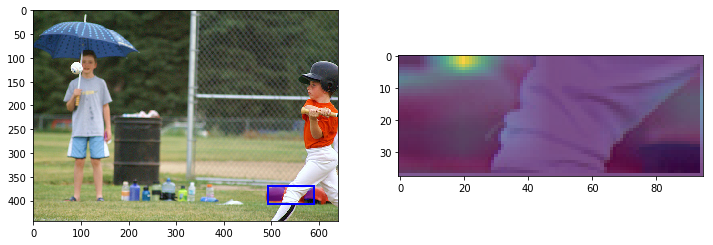

In [27]:
# visualize
tokens = expr.split()
print('sub(%.2f):' % entry['weights'][0], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['sub_attn'])]))
print('loc(%.2f):' % entry['weights'][1], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['loc_attn'])]))
print('rel(%.2f):' % entry['weights'][2], ''.join(['(%s,%.2f)'% (tokens[i], s) for i, s in enumerate(entry['rel_attn'])]))
# predict attribute on the predicted object
print(entry['pred_atts'])
# show prediction
plt.rcParams['figure.figsize'] = (12., 8.)
fig = plt.figure()
plt.subplot(121)
show_boxes(img_path, xywh_to_xyxy(np.vstack([entry['pred_box']])), ['blue'], texts=None, masks=[entry['pred_mask']])
plt.subplot(122)
show_attn(img_path, entry['pred_box'], entry['sub_grid_attn'])